In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [7]:
# constants
GAMMA = 0.9
WORLD_SIZE = 5
ACTIONS = [(1,0), (0,1), (-1,0), (0,-1)]

In [4]:
# gridworld implementation
class GridWorld:

    def __init__(self, A=(0,1), Ap=(4,1), Ar=10, B=(0,3), Bp=(2,3), Br=5):
        self.size = WORLD_SIZE
        self.A = A
        self.Ap = Ap
        self.Ar = Ar
        self.B = B
        self.Bp = Bp
        self.Br = Br

    def step(self, state, action):
        if state == self.A: return self.Ap, self.Ar
        if state == self.B: return self.Bp, self.Br
        s0, s1 = state
        a0, a1 = action
        x, y = s0 + a0, s1 + a1
        if x < 0 or y < 0 or x >= self.size or y >= self.size: return state, -1
        return (x, y), 0

In [5]:
# value iteration implementation
def value_iteration(env):
    v = np.zeros((WORLD_SIZE, WORLD_SIZE))
    delta = np.inf
    while delta > 1e-4:
        vp = np.zeros_like(v)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                for action in ACTIONS:
                    (x, y), reward = env.step((i,j), action)
                    vp[i, j] = max(vp[i, j], reward + GAMMA * v[x, y])
        delta = np.sum(np.abs(vp - v))
        v = vp
    return v

In [10]:
# generate data
env = GridWorld()
v_star = value_iteration(env)

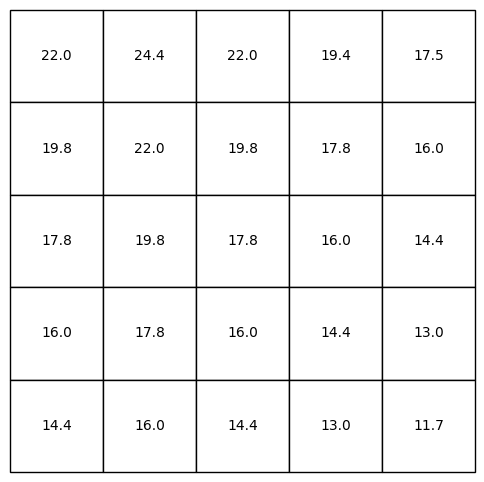

In [11]:
# generate figure 2.3
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_axis_off()
tb = Table(ax)

for i in range(WORLD_SIZE):
    for j in range(WORLD_SIZE):
        tb.add_cell(i, j, 0.2, 0.2, text=np.round(v_star[i][j], 1), loc='center')

ax.add_table(tb)
    
plt.show()